# purpose
- 事業×デバイス別に、一つの時系列データから次営業日の売上額を予測するモデルを作成すること

# TODOs
- 事業×デバイス別のデータ作成
- モデルに読み込ませる時系列データ(7:1)作成
- 学習データをLSTMに読み込ませて学習
- LSTMの性能評価
- 次営業日の売上額を予測

### 事業×デバイス別のデータ作成

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

You should consider upgrading via the 'pip install --upgrade pip' command.


In [ ]:
df = pd.read_csv('train_data.csv').sort_values('dt')

In [4]:
df.tail()

,dt,day_of_week,biz_category,category,nontax_amount
18607,2019-10-31,Thu,その他,01.multi_device,680631
18608,2019-10-31,Thu,電子書籍,02.pc_only,7568815
18609,2019-10-31,Thu,ライブコミュニケーション,02.pc_only,16702855
18610,2019-10-31,Thu,動画,02.pc_only,36492354
18611,2019-10-31,Thu,ゲーム,02.pc_only,182465176


In [5]:
df.nunique()

dt                1034
day_of_week          7
biz_category         6
category             3
nontax_amount    18604
dtype: int64

In [6]:
# 事業部別にデータを分割するためのリストを作成
biz_category_list = list(set(df['biz_category']))
print(biz_category_list)
data_list_tmp = [df[df['biz_category'] == biz_category] for biz_category in biz_category_list]

['その他', '動画', 'ゲーム', 'ライブコミュニケーション', '同人', '電子書籍']


In [7]:
# デバイス別にデータを分割するためのリストを作成
device_category_list = list(set(df['category']))
print(device_category_list)

data_list = []
for device_category in device_category_list:
    for data in data_list_tmp:
        data_list.append(data[data['category'] == device_category].loc[:, ['dt', 'nontax_amount']])

#print([len(data) for data in data_list])　　# 長さ確認

['03.sp_only', '02.pc_only', '01.multi_device']


In [8]:
data_list[0].head()

,dt,nontax_amount
2,2017-01-01,17160887
33,2017-01-02,16442985
53,2017-01-03,15660197
59,2017-01-04,17521247
88,2017-01-05,12123209


In [9]:
# 学習データ可視化する関数
def plot_sales(
    x, y, 
    category_list, data_list,
    num_biz_category, num_device_category, line_width):

    ax_list = []

    for i in range(len(category_list)):
        ax_list.append(
            {
                'ax':fig.add_subplot(num_biz_category, num_device_category, i + 1),
                'category':category_list[i],
                 'data':data_list[i]
                 }
            )

    for ax in ax_list:
        ax['ax'].tick_params(labelbottom='off')
        ax['ax'].set_title(ax['category'])
        ax['ax'].plot(x, y, data=ax['data'], linewidth=line_width)

In [10]:
category_list = []
for device_category in device_category_list:
    for biz_category in biz_category_list:
        category_list.append(biz_category + '_' + device_category)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


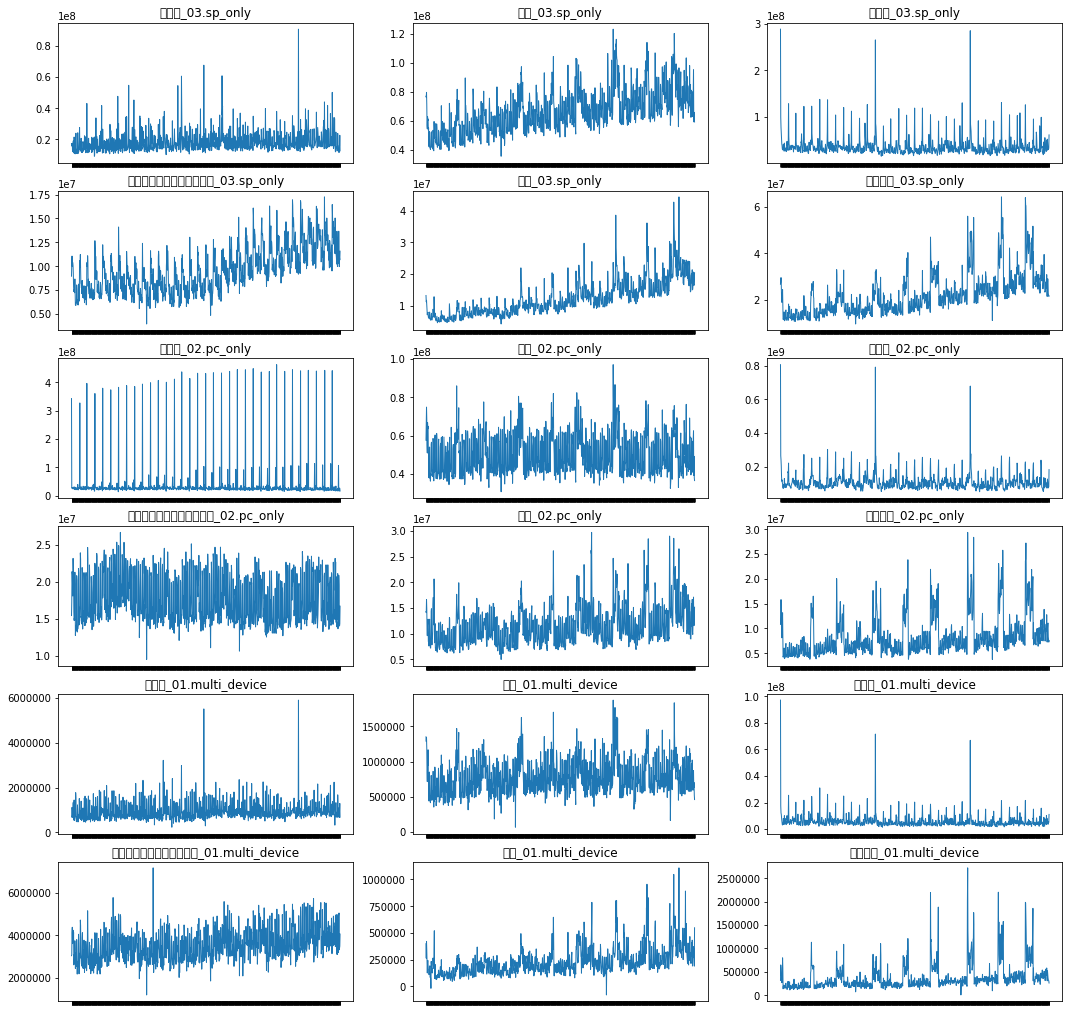

In [11]:
# 学習データ可視化
fig = plt.figure(figsize=(18, 18))

plot_sales('dt', 'nontax_amount', category_list, data_list, 6, 3, 1)

### モデルに読み込ませる時系列データ作成

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [13]:
#　売上のみのリスト作成
dataset_list = []
for data in data_list:
    dataset_list.append(data['nontax_amount'].values.astype('float32'))

In [14]:
np.random.seed(7)

# データの前処理
scaler_list = []
scaled_dataset_list = []

for data in dataset_list:
    scaler = MinMaxScaler(feature_range=(0, 1))
    # 前処理したデータを格納
    scaler_list.append(scaler.fit(data.reshape(-1, 1)))
    scaled_dataset_list.append(scaler.transform(data.reshape(-1, 1)))

In [15]:
# データをtrainとtestに分ける

train_size = int(len(scaled_dataset_list[0]) * 0.67)  #　モデルのトレーニングに使用するデータのサイズ
test_size = len(scaled_dataset_list[0]) - train_size 

train_list = [data[0:train_size,:] for data in scaled_dataset_list]
test_list = [data[train_size:len(data),:] for data in scaled_dataset_list]

In [16]:
print(np.array(train_list).shape)
print(np.array(test_list).shape)

(18, 692, 1)
(18, 342, 1)


In [17]:
# モデルに読み込ませるデータ生成
def generate_dataset(dataset, length_per_unit):
    # 時系列データ
    sequences = []
    # 正解データ
    target = []
    
    for i in range(len(dataset) - length_per_unit - 1):
        a = dataset[i:(i+length_per_unit), 0]
        sequences.append(a)
        target.append(dataset[i + length_per_unit, 0])
        
        X, Y = np.array(sequences), np.array(target)
    return X, Y

In [18]:
# 一つの時系列データの長さ
LENGTH_PER_UNIT = 7

#X, Y = generate_dataset(train_list[0], length_per_unit)
train_xy_list = [generate_dataset(train, LENGTH_PER_UNIT) for train in train_list] 
test_xy_list = [generate_dataset(test, LENGTH_PER_UNIT) for test in test_list]

In [19]:
# reshape input to be [samples, time steps, features]
train_x_list = [np.reshape(train_xy[0], (train_xy[0].shape[0], 1, train_xy[0].shape[1])) for train_xy in train_xy_list]
test_x_list = [np.reshape(test_xy[0], (test_xy[0].shape[0], 1, test_xy[0].shape[1])) for test_xy in test_xy_list] 

In [20]:
print(np.array(train_x_list).shape)
print(np.array(test_x_list).shape)

(18, 684, 1, 7)
(18, 334, 1, 7)


### 学習データをLSTMに読み込ませて学習

In [21]:
# LSTMの定義とfit
#!pip install --upgrade pip tensorboard
import math
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from keras import optimizers

# 最適化手法の設定
opt = optimizers.Adam()

def build_model(x_train, y_train, x_test, y_test):
    model = Sequential()
    # 隠れ層、LSTMに入力するデータの形を指定([バッチサイズ，step数，特徴の次元数]を指定する）
    model.add(LSTM(100, input_shape=(1, LENGTH_PER_UNIT)))
    model.add(Dense(1))
    model.add(Activation("linear"))
    # モデルのコンパイル
    model.compile(optimizer = opt,  # 最適化手法
                  loss = 'mean_squared_error',  # 損失関数
                  metrics = ['accuracy'])   # 評価関数
    
    model.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_test, y_test), verbose=1)#, run_tensorboard_locally=True
    
    return model

model_list = []

for i in range(len(category_list)):
    print(i)
    print(category_list[i])
    model_list.append(build_model(train_x_list[i], train_xy_list[i][1], test_x_list[i], test_xy_list[i][1])) #, run_tensorboard_locally=True
    print('')

Using TensorFlow backend.



0
その他_03.sp_only




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 684 samples, validate on 334 samples
Epoch 1/50





684/684 [==============================] - 5s 7ms/step - loss: 0.0075 - acc: 0.0015 - val_loss: 0.0077 - val_acc: 0.0000e+00
Epoch 2/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 0.0015 - val_loss: 0.0078 - val_acc: 0.0000e+00
Epoch 3/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 0.0015 - val_loss: 0.0076 - val_acc: 0.0000e+00
Epoch 4/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 0.0015 - val_loss: 0.0082 - val_acc: 0.0000e+00
Epoch 5/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 0.0015 - val_loss: 0.0077 - val_acc: 0.0000e+00
Epoch 6/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0066 - acc: 0.0015 - val_loss: 0.0083 - val_acc: 0.0000e+00
Epoch 7/50
684

Epoch 47/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0085 - acc: 0.0015 - val_loss: 0.0149 - val_acc: 0.0030
Epoch 48/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0085 - acc: 0.0015 - val_loss: 0.0157 - val_acc: 0.0030
Epoch 49/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0085 - acc: 0.0015 - val_loss: 0.0153 - val_acc: 0.0030
Epoch 50/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0085 - acc: 0.0015 - val_loss: 0.0160 - val_acc: 0.0030

2
ゲーム_03.sp_only
Train on 684 samples, validate on 334 samples
Epoch 1/50
684/684 [==============================] - 5s 7ms/step - loss: 0.0046 - acc: 0.0015 - val_loss: 0.0061 - val_acc: 0.0000e+00
Epoch 2/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0015 - val_loss: 0.0059 - val_acc: 0.0000e+00
Epoch 3/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0043 - acc: 0.0015 - val_loss: 0.0057 - val_acc: 0.0000e

684/684 [==============================] - 1s 1ms/step - loss: 0.0022 - acc: 0.0015 - val_loss: 0.0108 - val_acc: 0.0000e+00
Epoch 18/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0022 - acc: 0.0015 - val_loss: 0.0077 - val_acc: 0.0000e+00
Epoch 19/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0022 - acc: 0.0015 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 20/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0022 - acc: 0.0015 - val_loss: 0.0074 - val_acc: 0.0030
Epoch 21/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0022 - acc: 0.0015 - val_loss: 0.0075 - val_acc: 0.0030
Epoch 22/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0023 - acc: 0.0015 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 23/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0022 - acc: 0.0015 - val_loss: 0.0077 - val_acc: 0.0000e+00
Epoch 24/50
684/684 [==============================] - 1s 1ms

684/684 [==============================] - 1s 2ms/step - loss: 0.0189 - acc: 0.0015 - val_loss: 0.0216 - val_acc: 0.0000e+00
Epoch 38/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0187 - acc: 0.0015 - val_loss: 0.0233 - val_acc: 0.0000e+00
Epoch 39/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0187 - acc: 0.0015 - val_loss: 0.0218 - val_acc: 0.0000e+00
Epoch 40/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0184 - acc: 0.0015 - val_loss: 0.0218 - val_acc: 0.0000e+00
Epoch 41/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0184 - acc: 0.0015 - val_loss: 0.0208 - val_acc: 0.0000e+00
Epoch 42/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0183 - acc: 0.0015 - val_loss: 0.0216 - val_acc: 0.0000e+00
Epoch 43/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0183 - acc: 0.0015 - val_loss: 0.0207 - val_acc: 0.0000e+00
Epoch 44/50
684/684 [==============================] 

684/684 [==============================] - 1s 1ms/step - loss: 0.0134 - acc: 0.0015 - val_loss: 0.0147 - val_acc: 0.0000e+00
Epoch 7/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0135 - acc: 0.0015 - val_loss: 0.0161 - val_acc: 0.0000e+00
Epoch 8/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0131 - acc: 0.0015 - val_loss: 0.0142 - val_acc: 0.0000e+00
Epoch 9/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0130 - acc: 0.0015 - val_loss: 0.0142 - val_acc: 0.0000e+00
Epoch 10/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0131 - acc: 0.0015 - val_loss: 0.0155 - val_acc: 0.0000e+00
Epoch 11/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0128 - acc: 0.0015 - val_loss: 0.0146 - val_acc: 0.0000e+00
Epoch 12/50
684/684 [==============================] - 1s 1ms/step - loss: 0.0132 - acc: 0.0015 - val_loss: 0.0141 - val_acc: 0.0000e+00
Epoch 13/50
684/684 [==============================] - 1

684/684 [==============================] - 1s 2ms/step - loss: 0.0055 - acc: 0.0000e+00 - val_loss: 0.0109 - val_acc: 0.0060
Epoch 25/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0055 - acc: 0.0000e+00 - val_loss: 0.0121 - val_acc: 0.0060
Epoch 26/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0055 - acc: 0.0000e+00 - val_loss: 0.0112 - val_acc: 0.0060
Epoch 27/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0054 - acc: 0.0000e+00 - val_loss: 0.0112 - val_acc: 0.0060
Epoch 28/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0054 - acc: 0.0000e+00 - val_loss: 0.0108 - val_acc: 0.0060
Epoch 29/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0054 - acc: 0.0000e+00 - val_loss: 0.0125 - val_acc: 0.0060
Epoch 30/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0054 - acc: 0.0000e+00 - val_loss: 0.0108 - val_acc: 0.0060
Epoch 31/50
684/684 [==============================] 

684/684 [==============================] - 1s 2ms/step - loss: 0.0110 - acc: 0.0015 - val_loss: 0.0137 - val_acc: 0.0030
Epoch 44/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0110 - acc: 0.0015 - val_loss: 0.0137 - val_acc: 0.0030
Epoch 45/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0110 - acc: 0.0015 - val_loss: 0.0136 - val_acc: 0.0030
Epoch 46/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0111 - acc: 0.0015 - val_loss: 0.0137 - val_acc: 0.0030
Epoch 47/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0110 - acc: 0.0015 - val_loss: 0.0143 - val_acc: 0.0000e+00
Epoch 48/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0109 - acc: 0.0015 - val_loss: 0.0139 - val_acc: 0.0000e+00
Epoch 49/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0109 - acc: 0.0015 - val_loss: 0.0133 - val_acc: 0.0030
Epoch 50/50
684/684 [==============================] - 1s 2ms/step - loss

684/684 [==============================] - 1s 2ms/step - loss: 0.0090 - acc: 0.0015 - val_loss: 0.0139 - val_acc: 0.0000e+00
Epoch 3/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0087 - acc: 0.0015 - val_loss: 0.0124 - val_acc: 0.0000e+00
Epoch 4/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0085 - acc: 0.0015 - val_loss: 0.0161 - val_acc: 0.0000e+00
Epoch 5/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0084 - acc: 0.0015 - val_loss: 0.0112 - val_acc: 0.0000e+00
Epoch 6/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0082 - acc: 0.0015 - val_loss: 0.0108 - val_acc: 0.0000e+00
Epoch 7/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0082 - acc: 0.0015 - val_loss: 0.0112 - val_acc: 0.0000e+00
Epoch 8/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0081 - acc: 0.0015 - val_loss: 0.0111 - val_acc: 0.0000e+00
Epoch 9/50
684/684 [==============================] - 1s 1m

Epoch 19/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0094 - val_acc: 0.0000e+00
Epoch 20/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0092 - val_acc: 0.0000e+00
Epoch 21/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0090 - val_acc: 0.0000e+00
Epoch 22/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 23/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0092 - val_acc: 0.0000e+00
Epoch 24/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0000e+00
Epoch 25/50
684/684 [==============================] - 1s 2ms/step - loss: 0.0031 - acc: 0.0000e+00 - val_loss: 0.0091 - val_acc: 0.0000e+00
Epoch 26/50
6

### LSTMの性能評価

In [23]:
# 予測
train_predict_list = []
test_predict_list = []
for i in range(len(category_list)):
    train_predict_list.append(model_list[i].predict(train_x_list[i]))
    test_predict_list.append(model_list[i].predict(test_x_list[i]))


# 前処理したデータを元に戻す
rescaled_train_predict_list = []
rescaled_train_y_list = []
rescaled_test_predict_list = []
rescaled_test_y_list = []

for i in range(len(category_list)):
    rescaled_train_predict_list.append(scaler_list[i].inverse_transform(train_predict_list[i]))  # train_predict_list[i].shape = (561, 1)
    rescaled_train_y_list.append(scaler_list[i].inverse_transform([train_xy_list[i][1]]))  # train_xy_list[i][1].shape = (561, )
    rescaled_test_predict_list.append(scaler_list[i].inverse_transform(test_predict_list[i]))  # test_predict_list[i].shape = (241, 1)
    rescaled_test_y_list.append(scaler_list[i].inverse_transform([test_xy_list[i][1]]))  # test_xy_list.shape = (241, )


# 二乗平均誤差を計算する　
rescaled_train_score_list = []
rescaled_test_score_list = []
train_score_list = []
test_score_list = []

for i in range(len(category_list)):
    rescaled_train_score_list.append(math.sqrt(mean_squared_error(rescaled_train_y_list[i][0], rescaled_train_predict_list[i][:,0])))
    rescaled_test_score_list.append(math.sqrt(mean_squared_error(rescaled_test_y_list[i][0], rescaled_test_predict_list[i][:,0])))
    train_score_list.append(math.sqrt(mean_squared_error(train_xy_list[i][1], train_predict_list[i][:,0])))
    test_score_list.append(math.sqrt(mean_squared_error(test_xy_list[i][1], test_predict_list[i][:,0])))

In [81]:
# 最終的な誤差の平均
loss_av = 0
val_loss_av = 0
for i in range(len(category_list)):
    loss_av += model_list[i].history.history['loss'][49]
    val_loss_av += model_list[i].history.history['val_loss'][49]

print(f'loss average :{loss_av/len(category_list)}')
print(f'validation loss average :{val_loss_av/len(category_list)}')

loss average :0.006634660221713269
validation loss average :0.010880967130375886


In [26]:
# 誤差の平均

print(f'Train Score Av: {sum(train_score_list)/len(train_score_list)}')
print(f'Test Score Av: {sum(test_score_list)/len(test_score_list)}')

Train Score Av: 0.0774531710570162
Test Score Av: 0.10106702182978934


/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


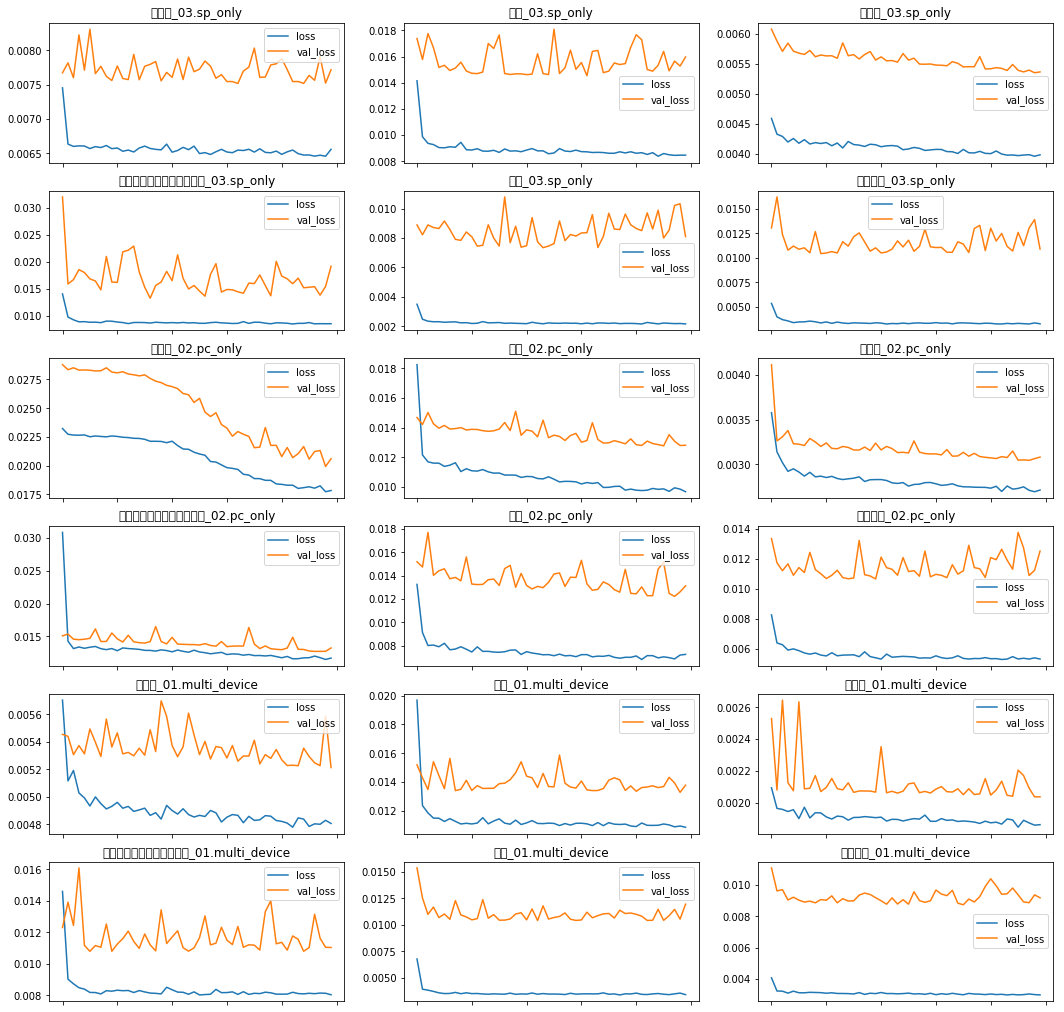

In [80]:
# lossの推移
fig = plt.figure(figsize=(18, 18))
ax_list = []

for i in range(len(category_list)):
    ax_list.append(
        {
            'ax':fig.add_subplot(6, 3, i + 1),
            'category':category_list[i],
            'loss_data':model_list[i].history.history['loss'],
            'val_loss_data':model_list[i].history.history['val_loss']
                }
        )

for ax in ax_list:
    ax['ax'].tick_params(labelbottom='off')
    ax['ax'].set_title(ax['category'])
    ax['ax'].plot(ax['loss_data'], label='loss')
    ax['ax'].plot(ax['val_loss_data'], label='val_loss')
    ax['ax'].legend()

### 次の日の売上を予測


    その他_03.sp_only : 
       - Train 誤差: 6523484.6074249325
       - Test 誤差: 7148190.9945773585
       - 標準偏差: 6826004.089432395 
    


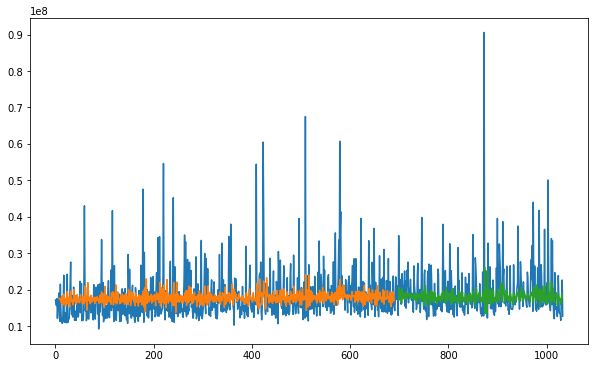


    動画_03.sp_only : 
       - Train 誤差: 7969691.791487307
       - Test 誤差: 11044072.972027214
       - 標準偏差: 14895288.584010873 
    


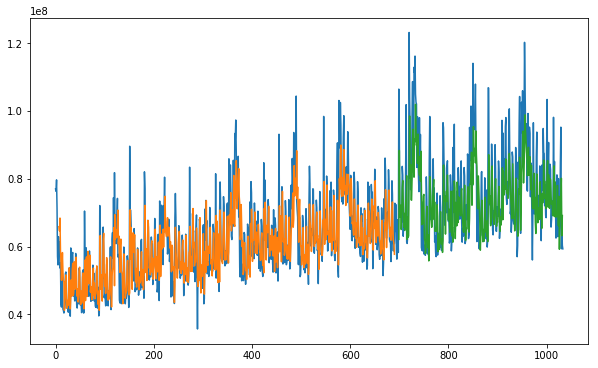


    ゲーム_03.sp_only : 
       - Train 誤差: 17105875.006464444
       - Test 誤差: 20052275.928888068
       - 標準偏差: 21603522.01084523 
    


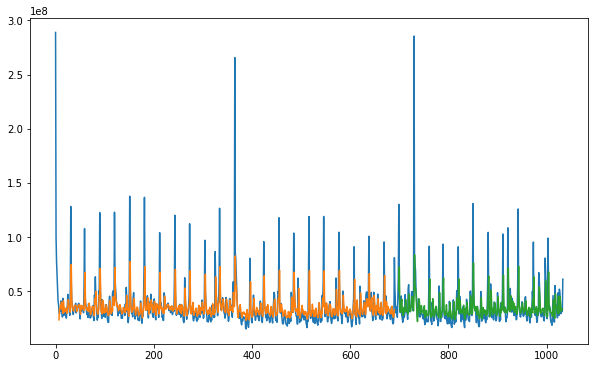


    ライブコミュニケーション_03.sp_only : 
       - Train 誤差: 1245474.0172229
       - Test 誤差: 1845143.5262134622
       - 標準偏差: 2364669.66353116 
    


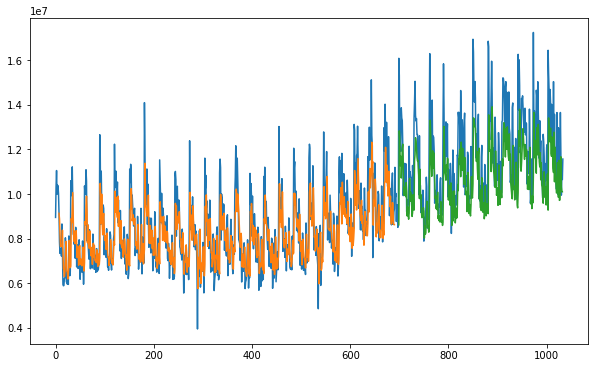


    同人_03.sp_only : 
       - Train 誤差: 1901445.8259475997
       - Test 誤差: 3625322.658112872
       - 標準偏差: 5644539.402391638 
    


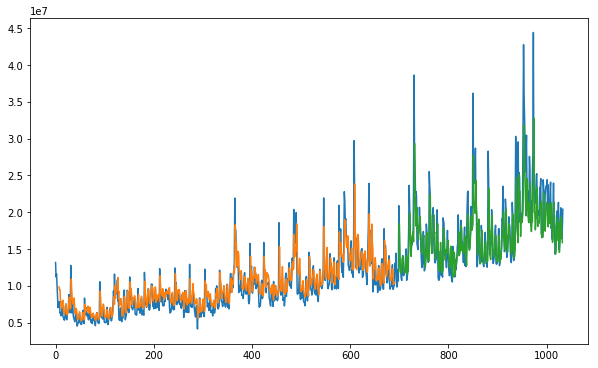


    電子書籍_03.sp_only : 
       - Train 誤差: 3113583.3402845934
       - Test 誤差: 5732444.95186942
       - 標準偏差: 8768528.651852872 
    


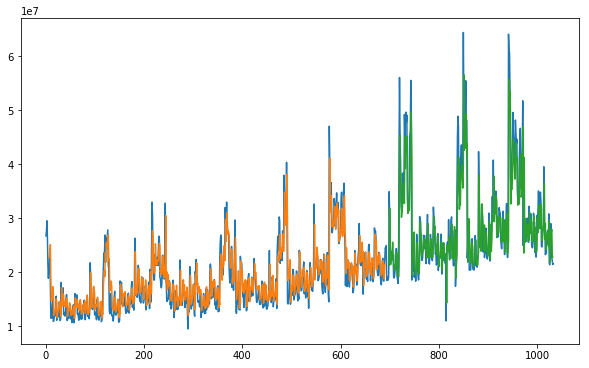


    その他_02.pc_only : 
       - Train 誤差: 59202109.769417584
       - Test 誤差: 64257093.26665396
       - 標準偏差: 70475613.64465453 
    


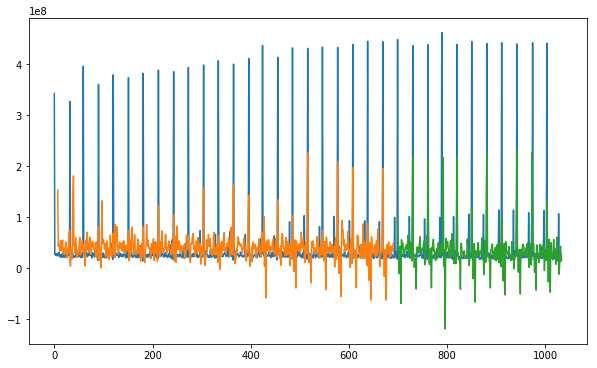


    動画_02.pc_only : 
       - Train 誤差: 6508147.667013361
       - Test 誤差: 7500913.770771389
       - 標準偏差: 10511440.34012744 
    


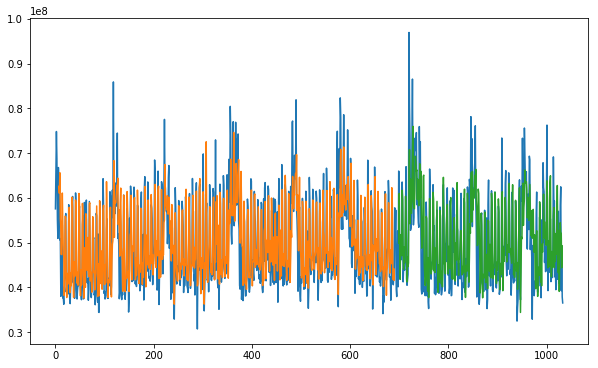


    ゲーム_02.pc_only : 
       - Train 誤差: 39247108.62892595
       - Test 誤差: 41962305.51833845
       - 標準偏差: 53321499.11628474 
    


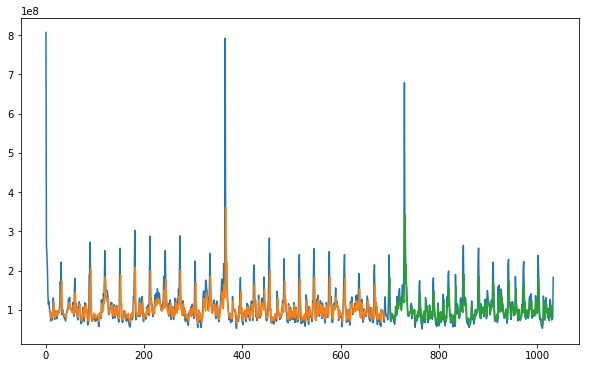


    ライブコミュニケーション_02.pc_only : 
       - Train 誤差: 1852246.9112136164
       - Test 誤差: 1981296.754417291
       - 標準偏差: 3181434.774924605 
    


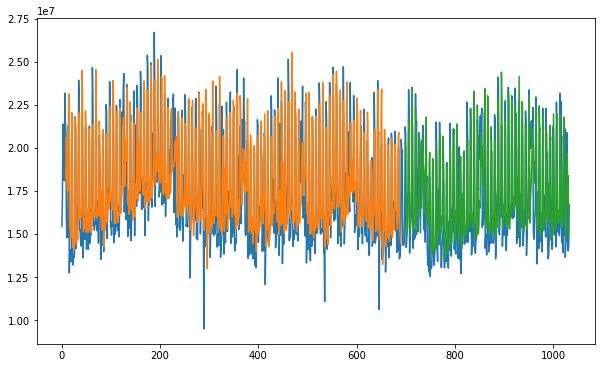


    同人_02.pc_only : 
       - Train 誤差: 2033791.1456350416
       - Test 誤差: 2840939.2990131327
       - 標準偏差: 3900965.832883983 
    


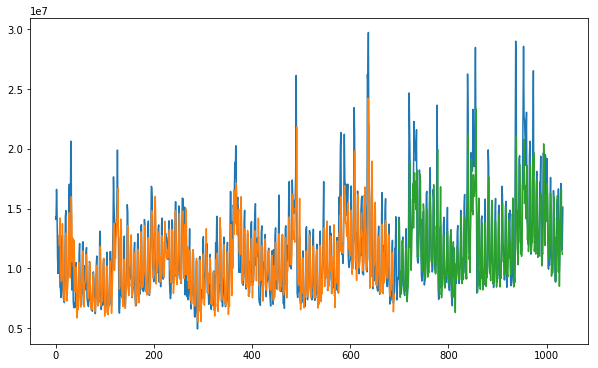


    電子書籍_02.pc_only : 
       - Train 誤差: 1839401.409018902
       - Test 誤差: 2866026.2338772803
       - 標準偏差: 3990131.031664336 
    


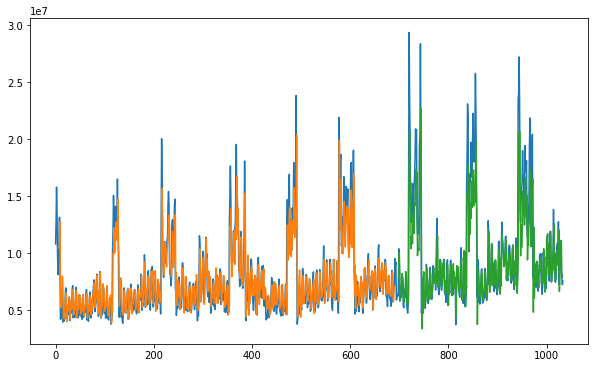


    その他_01.multi_device : 
       - Train 誤差: 389578.5974592977
       - Test 誤差: 408012.861458437
       - 標準偏差: 419053.8329108137 
    


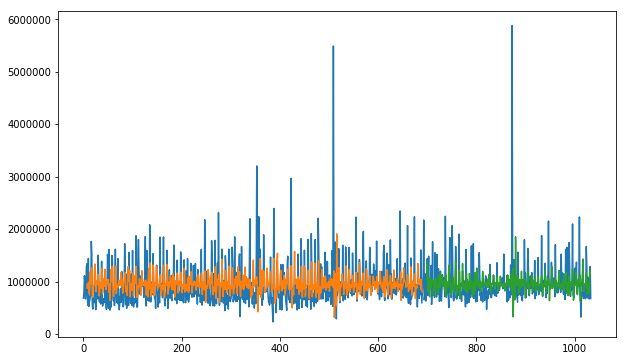


    動画_01.multi_device : 
       - Train 誤差: 187749.59109321577
       - Test 誤差: 212587.61405318536
       - 標準偏差: 245484.11791264563 
    


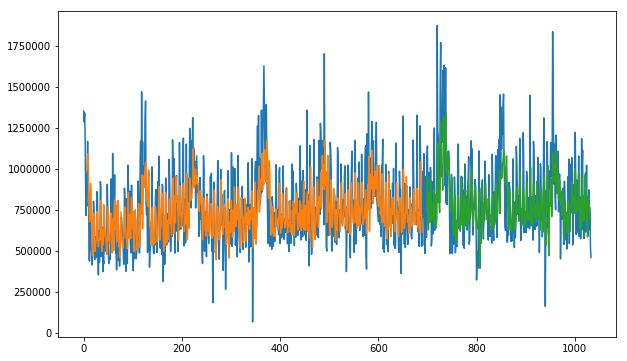


    ゲーム_01.multi_device : 
       - Train 誤差: 4110168.494113306
       - Test 誤差: 4318375.097011773
       - 標準偏差: 5243687.198011959 
    


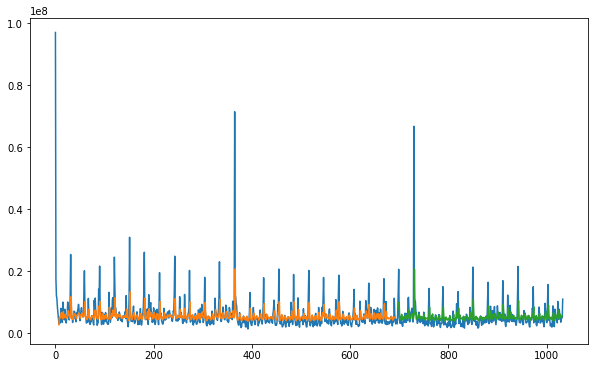


    ライブコミュニケーション_01.multi_device : 
       - Train 誤差: 534732.0439754749
       - Test 誤差: 629410.8876184314
       - 標準偏差: 734156.0195522903 
    


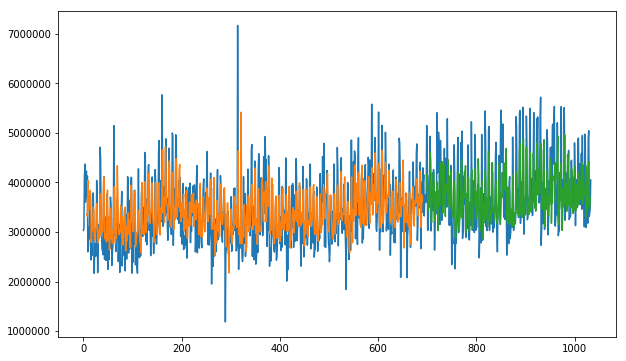


    同人_01.multi_device : 
       - Train 誤差: 71305.37163867986
       - Test 誤差: 129807.47610749752
       - 標準偏差: 131672.5634615997 
    


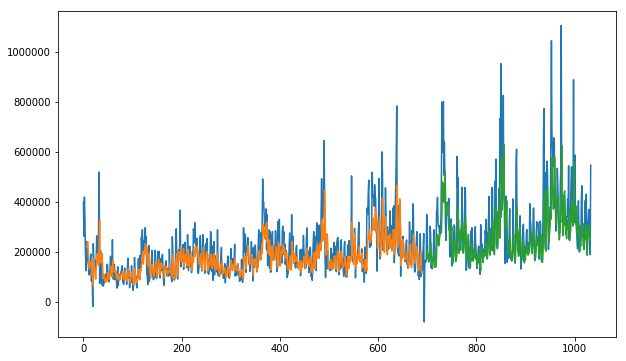


    電子書籍_01.multi_device : 
       - Train 誤差: 147292.40661031994
       - Test 誤差: 260637.64902020915
       - 標準偏差: 285913.24108159315 
    


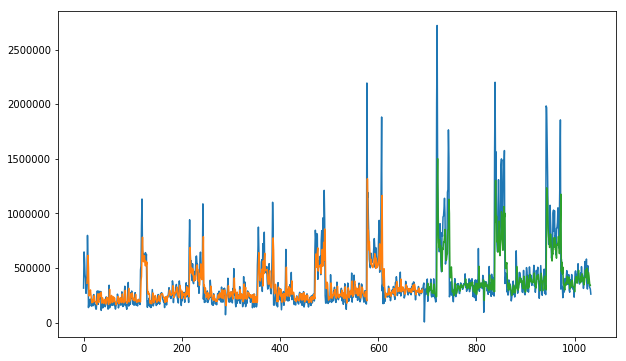

In [46]:
for i in range(len(category_list)):
    print(f'''
    {category_list[i]} : 
       - Train 誤差: {rescaled_train_score_list[i]}
       - Test 誤差: {rescaled_test_score_list[i]}
       - 標準偏差: {data_list[i]['nontax_amount'].std()} 
    ''')
    
     # trainの予測データをプロットするために変換
    dataset = scaled_dataset_list[i]

    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[LENGTH_PER_UNIT:len(rescaled_train_predict_list[i])+LENGTH_PER_UNIT, :] = rescaled_train_predict_list[i]


    # testの予測データをプロットするために変換

    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(rescaled_train_predict_list[i])+(LENGTH_PER_UNIT*2)+1:len(dataset)-1, :] = rescaled_test_predict_list[i]


    # plot baseline and predictions

#     plt.figure(figsize=(12, 8))
    plt.figure(figsize=(10, 6))
    plt.plot(scaler_list[i].inverse_transform(dataset))
    plt.plot(train_predict_plot)
    plt.plot(test_predict_plot)
    plt.show()

### まとめ
- 事業×デバイス別に、前営業日の売上額から次営業日の売上額を予測するモデルを作った
- 2016-01-01 ~ 2019-10-31の期間のデータのうち前半2/3を学習データ、後半1/3を検証用データとして用いた
- 評価指標はRMSEを用いた
    - 精度がよくない
        - 誤差率：10^-2%のオーダー
        - 誤差：100万円のオーダー